# Shouten article plots

In [12]:
import numpy as np
import pandas as pd
import pyampute
from pyampute.ampute import MultivariateAmputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
import os
import matplotlib.pyplot as plt

## Data generation 

In [13]:
def data_gener(n, ro):
    #continious data
    mu = np.array([5, 5, 10])
    Sigma = np.array([[1, ro, ro], [ro, 1, ro], [ro, ro, 1]])
    X_cont = np.random.multivariate_normal(mu, Sigma, size = n)
    #X_cont = pd.DataFrame(X_con, columns = ['Y1','Y2','X1'])
    #X_cont = pd.DataFrame(X_cont)


#     #discrete data
#     from scipy.stats import poisson

#     lamb = 0.5
#     X_discr = poisson.rvs(lamb, size = n)
#     X_discr = np.expand_dims(X_discr, axis = 1)

#     #categorical data
#     n_cat = 5
#     X_cat = np.random.binomial(n = n_cat, p = 0.5, size = n)
#     X_cat = np.expand_dims(X_cat, axis = 1)

#     #all together
#     X_complete = np.concatenate((X_cont, X_discr, X_cat), axis = 1)

#     #X_complete = pd.DataFrame(X_complete)
#     #X_complete.iloc[:, 3] = X_complete.iloc[:, 3].astype('category')
#     #X_complete.iloc[:, 3].cat.categories = [0, 1, 2, 3, 4, 5]
    #X_complete.head()
    return X_cont

## CC

In [14]:
propor = 0.2
corrs = np.arange(0.1, 1, 0.1)

df_bias_cc = pd.DataFrame(columns = ['full', 'MCAR', 'MAR', 'MNAR'])

for cor in corrs:
    
    n = 0
    df_means = pd.DataFrame(columns = ['mean_full', 'mean_MCAR', 'mean_MAR', 'mean_MNAR'])

    for n in np.arange(100):

        X_full = data_gener(1000, cor)
        df_means.loc[n, 'mean_full'] = X_full[:,0].mean() 

        #___MCAR________
        
        ma = MultivariateAmputation(
            patterns = [ {'incomplete_vars': [0,1], 'mechanism': "MCAR"} ],
            prop = propor
        )
        X_miss = ma.fit_transform(X_full)

        X_m = pd.DataFrame(X_miss, columns = ['Y1','Y2','X1'])
        cc = X_m.dropna()
        df_means.loc[n, 'mean_MCAR'] = cc['Y1'].mean() 


        #___MAR________
        
        ma = MultivariateAmputation(
            patterns = [ {'incomplete_vars': [0,1], 'weights': [0,0,1], 'mechanism': "MAR"} ],
            prop = propor
        )
        X_miss = ma.fit_transform(X_full)
        
        X_m = pd.DataFrame(X_miss, columns = ['Y1','Y2','X1'])
        cc = X_m.dropna()
        df_means.loc[n, 'mean_MAR'] = cc['Y1'].mean() 

        
        #___MNAR________
        
        ma = MultivariateAmputation(
            patterns = [ {'incomplete_vars': [0,1], 'weights': [1,0,0], 'mechanism': "MAR+MNAR"} ],
            prop = propor
        )
        X_miss = ma.fit_transform(X_full)
        X_m = pd.DataFrame(X_miss, columns = ['Y1','Y2','X1'])
        cc = X_m.dropna()
        df_means.loc[n, 'mean_MNAR'] = cc['Y1'].mean() 

        
    df_bias_cc.loc[cor*10, 'full'] = df_means['mean_full'].mean() - df_means['mean_full'].mean() 
    df_bias_cc.loc[cor*10, 'MCAR'] = df_means['mean_MCAR'].mean() - df_means['mean_full'].mean()
    df_bias_cc.loc[cor*10, 'MAR'] = df_means['mean_MAR'].mean() - df_means['mean_full'].mean()
    df_bias_cc.loc[cor*10, 'MNAR'] = df_means['mean_MNAR'].mean() - df_means['mean_full'].mean()

    
df_bias_cc

,full,MCAR,MAR,MNAR
1.0,0.0,0.000209,-0.017433,-0.174037
2.0,0.0,-0.000969,-0.035571,-0.172617
3.0,0.0,-0.001757,-0.05377,-0.173645
4.0,0.0,-0.002969,-0.06537,-0.173492
5.0,0.0,-0.002766,-0.08543,-0.174681
6.0,0.0,-0.000978,-0.103502,-0.17481
7.0,0.0,0.001496,-0.122523,-0.174597
8.0,0.0,-0.000034,-0.136808,-0.174722
9.0,0.0,0.000393,-0.158655,-0.171117


In [15]:
CC = df_bias_cc

<AxesSubplot:>

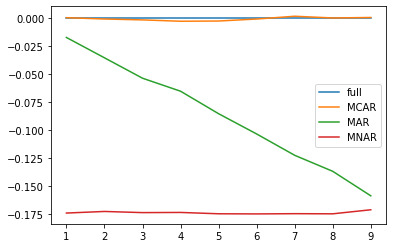

In [16]:
CC.plot()

## MICE

In [17]:
propor = 0.2
corrs = np.arange(0.1, 1, 0.1)

df_bias_mice = pd.DataFrame(columns = ['full', 'MCAR', 'MAR', 'MNAR'])

for cor in corrs:
    
    n = 0
    df_means = pd.DataFrame(columns = ['mean_full', 'mean_MCAR', 'mean_MAR', 'mean_MNAR'])

    for n in np.arange(100):

        X_full = data_gener(1000, cor)
        df_means.loc[n, 'mean_full'] = X_full[:,0].mean() 
        
    
        
        #___MCAR________
        
        ma = MultivariateAmputation(
            patterns = [ {'incomplete_vars': [0,1], 'mechanism': "MCAR"} ],
            prop = propor
        )
        X_miss_MCAR = ma.fit_transform(X_full)

        #X_m_MCAR = pd.DataFrame(X_miss_MCAR, columns = ['Y1','Y2','X1'])
        #imp = IterativeImputer(max_iter=50, random_state = 0).fit_transform(X_m)
        imp_MCAR = IterativeImputer(max_iter=50, random_state = 0, estimator = BayesianRidge()).fit_transform(X_miss_MCAR)
        df_means.loc[n, 'mean_MCAR'] = imp_MCAR[:,0].mean()
        #df_means.loc[n, 'mean_MCAR'] = imp['Y1'].mean() 


        #___MAR________
        
        ma = MultivariateAmputation(
            patterns = [ {'incomplete_vars': [0,1], 'weights': [0,0,1], 'mechanism': "MAR"} ],
            prop = propor
        )
        X_miss_MAR = ma.fit_transform(X_full)
        
        #X_m_MAR = pd.DataFrame(X_miss, columns = ['Y1','Y2','X1'])
        imp_MAR = IterativeImputer(max_iter=50, random_state = 0, estimator = BayesianRidge()).fit_transform(X_miss_MAR)
        df_means.loc[n, 'mean_MAR'] = imp_MAR[:,0].mean()

        
        #___MNAR________
        
        ma = MultivariateAmputation(
            patterns = [ {'incomplete_vars': [0,1], 'weights': [1,0,0], 'mechanism': "MAR+MNAR"} ],
            prop = propor
        )
        X_miss_MNAR = ma.fit_transform(X_full)
        imp_MNAR = IterativeImputer(max_iter=50, random_state = 0, estimator = BayesianRidge()).fit_transform(X_miss_MNAR)
        df_means.loc[n, 'mean_MNAR'] = imp_MNAR[:,0].mean() 

        
    df_bias_mice.loc[cor*10, 'full'] = df_means['mean_full'].mean() - df_means['mean_full'].mean() 
    df_bias_mice.loc[cor*10, 'MCAR'] = df_means['mean_MCAR'].mean() - df_means['mean_full'].mean()
    df_bias_mice.loc[cor*10, 'MAR'] = df_means['mean_MAR'].mean() - df_means['mean_full'].mean()
    df_bias_mice.loc[cor*10, 'MNAR'] = df_means['mean_MNAR'].mean() - df_means['mean_full'].mean()

    
df_bias_mice

,full,MCAR,MAR,MNAR
1.0,0.0,0.002264,-0.002468,-0.171973
2.0,0.0,0.003166,-0.005535,-0.16729
3.0,0.0,-0.000816,-0.000082,-0.159297
4.0,0.0,0.001097,0.001907,-0.146763
5.0,0.0,-0.00201,-0.000583,-0.134607
6.0,0.0,0.000316,-0.000259,-0.116518
7.0,0.0,-0.00228,0.000294,-0.092583
8.0,0.0,-0.000183,0.000022,-0.06778
9.0,0.0,-0.000474,0.000077,-0.036126


In [18]:
MICE = df_bias_mice

<AxesSubplot:>

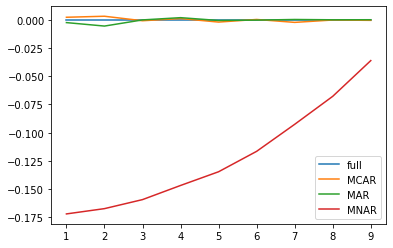

In [19]:
MICE.plot()